In [674]:
# Getting the input data
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
from scipy import stats 
import shutil
from io import StringIO
import statsmodels.formula.api as smf


# Set the directory, import dimensions file, point to sample folder

In [675]:
#Set the current sample ID. Must be identical to the file path name

# File format should be /Dropbox (BeamTeam)/IACMI Team Folder/Test Data/November 2017 Tensile Tests 17081-01/Sample ID/
# The beginning of the directory name will be specific to your specific machine. Mine is /Users/nicolethomas/

# Be sure to name all your DIC csv export files "DIC Strain"

os.chdir('/Users/nicolethomas/Dropbox (BeamTeam)/IACMI Team Folder/Test Data/November 2017 Tensile Tests 17081-01/')

# Read in the dimensions file, in order of your Sample_ID list above
dimensions = pd.read_excel("TPI Sample 17081-01 Dimensions.xlsx", skiprows=3, 
    usecols=[0,5,10]) 
print(dimensions)

# Set the name of your Sample IDs here for the analysis you want to perform
Sample_ID = ['17081-01-T2','17081-01-T5','17081-01-T7','17081-01-T8',
             '17081-01-T10','17081-01-T11','17081-01-T14','17081-01-T16',
            '17081-01-FT2','17081-01-FT5','17081-01-FT7','17081-01-FT8','17081-01-FT8_2',
            '17081-01-FT10','17081-01-FT11','17081-01-FT14','17081-01-FT16',]
#Sample_column_index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]  # This identifies the index of the sample in the dimensions file

for sample in Sample_ID:

# Set index of the column in the dimensions file for the sample you're running here. Remember, column 1 = 0 index, etc...
    Sample_column_index = 0

#Setting the directory to the sample's folder
    os.chdir(('/Users/nicolethomas/Dropbox (BeamTeam)/IACMI Team Folder/Test Data/November 2017 Tensile Tests 17081-01/%s') %sample)

    
    w = dimensions['w_avg (mm)'][Sample_column_index]/1000
    #print (("Sample Width = %f m") %w)

    t = dimensions['t_avg (mm)'][Sample_column_index]/1000    
    #print (("Sample Width = %f m") %t)

    Area = w*t
    #print (("Sample XC Area = %f m") %Area) 

    Sample ID  w_avg (mm)  t_avg (mm)
0          T2   25.433867    3.298190
1          T5   25.408467    3.246543
2          T7   25.052867    3.285067
3          T8   25.476200    3.153410
4         T10   25.391533    3.319357
5         T11   25.374600    3.288453
6         T14   25.383067    3.292263
7         T16   25.383067    3.365923
8         FT2   15.163800    3.346450
9         FT5   15.096067    3.147907
10        FT7   15.045267    3.238500
11        FT8   15.096067    3.196167
12        FT8   15.096067    3.196167
13       FT10   15.036800    3.437467
14       FT11   15.074053    3.363383
15       FT14   15.113000    3.378623
16       FT16   15.113000    3.412913


# Read MTS Output file & skip lines with heading info

In [676]:
# Skip irrelevant lines of setup code imbedded in the data)

def scrub_file(filename, separator=',', skip_header=0):
    # initialize variables
    line = ""
    contents = ""
    lineno = 0
    numfields = 0
    # what conversion are we performing? what does it return if the
    # conversion fails?
    def tofloat(x):
        try:
            return float(x)
        except ValueError:
            return np.nan
    # this is going to handle reading a line from the file, and automatically
    # do anything else we need, such as keep track of which line number
    # we're on.
    def readline():
        nonlocal line, fstream
        #global line
        line = fstream.readline()
        #lineno += 1
        return line
    # set the converter
    convert = tofloat
    # read the file
    with open(filename) as fstream:
        # pass header rows straight through
        for _ in range(skip_header):
            contents.append(readline(fstream))
        # check how many fields fail conversion
        while readline():
            # process the line into fields (comma-separated by default)
            fields = [convert(field) for field in line.split(separator)]
            # how many of these fields are not NaN when an attempt is made
            # to convert them to a float?
            notnan = np.sum(~np.isnan(fields))
            # **This is where all the work is done!** How do you know if a row is
            # bad? Is it bad if all fields fail the conversion? All-but-one? All-but-two?
            # You have to look at the source file and make this determination, then
            # change this inequality. Only rows that pass the test are kept.
            if notnan > 0:
                contents += line
            # update the numfields variable -- this tracks the row with the most
            # number of fields.
            numfields = max(notnan, numfields)
    # now return the good lines (a.k.a. records) as a StringIO object. (StringIO
    # allows you to read from a string object as if it were a file.)
    return StringIO(contents)

# This is where the MTS file is read in
tensile = pd.read_csv("DAQ- Time, … - (Timed).csv", skiprows=3, 
    usecols=[0,1,6], 
    names = ['Time','Axial Force','Axial Extensometer']).dropna(axis = 0)

In [677]:
# This is the code you'd use if you needed to process the crap out of the MTS file.
# It is scrubbed using the scrub_file function above 
# in case MTS did some silly shit and added random header rows in the middle of the data. 

# BUT for some reason the scrub_file function isn't working for this analysis and deletes all the data. Stupid.

# tensile = pd.read_csv(scrub_file("DAQ- Time, … - (Timed).csv"), skiprows=3, 
#     usecols=[0,1,6], 
#     names = ['Time','Axial Force','Axial Extensometer']).dropna(axis = 0)

In [678]:
#Check that the MTS input parameters are correct

#     print('Input_size:')
#     print(tensile.shape)
#     print(tensile.head(5))

# Call the DIC Data

In [679]:
#Setting the directory to the sample's Transverse DIC Data File

DIC_Data = pd.read_csv("DIC Strain.csv", skiprows = 2,
     usecols=[0,9], 
     names = ['Index','exx - engr.']).dropna(axis = 0)

#     print(DIC_Data.shape)
#     print(DIC_Data.head())

Max DIC Error is 4.17051e-05


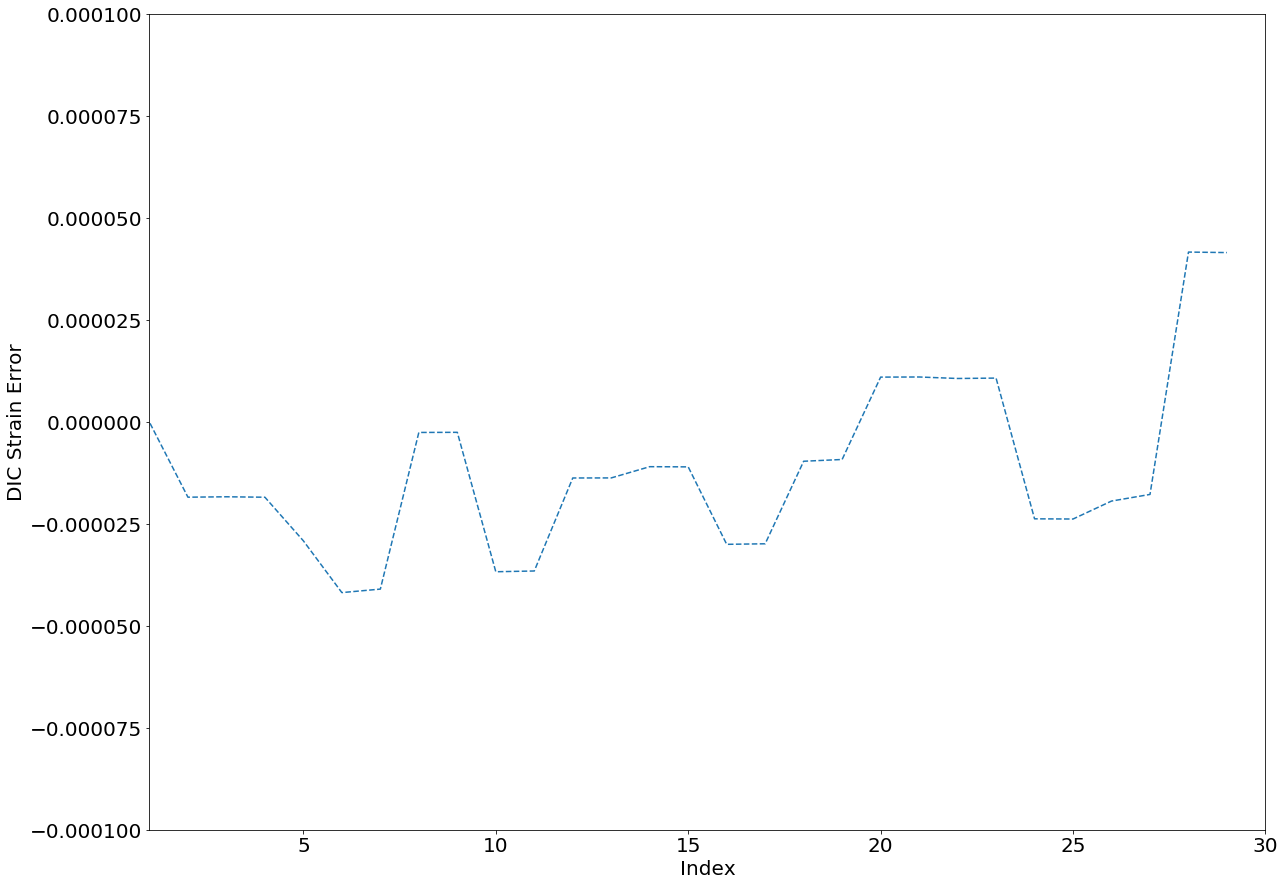

In [680]:
#Separate the static frames for the error analysis
DIC_strain_error = []
DIC_error_index = []
new_strain = []
new_index =[]
for strain, index in zip(DIC_Data['exx - engr.'], DIC_Data['Index']):
    if strain < 0.0001:
        DIC_strain_error.append(strain)
        DIC_error_index.append(index)
    else: 
        new_strain.append(strain)
        new_index.append(index)

#print(new_strain)

# print('DIC Error:')
# print(DIC_strain_error)
# print('Index:')
# print(DIC_error_index)
Max_error = max(DIC_strain_error)
print(('Max DIC Error is %s') %Max_error)

num_still_shots = len(DIC_strain_error)

plt.figure(figsize = (20,15))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.plot(DIC_error_index, DIC_strain_error,'--')
    #plt.plot(b,a,'-')
    #plt.plot(g,c,'-')
plt.xlabel('Index', fontsize = 20)
plt.ylabel('DIC Strain Error', fontsize = 20)
plt.axis([1,num_still_shots,-0.0001,0.0001])
plt.savefig('DIC_Strain_Error.tiff')
plt.show()

In [681]:
# # Calculate DIC strain for ISO 527
# iso_527_DIC_strain = []
# #Force_in_strain_range = []
# for ext, force in zip(tensile['Axial Extensometer'], tensile['Axial Force']):
#     if ext > 0.001 and ext < 0.003:
#         iso_527_strain.append(ext)
#         Force_in_strain_range.append(force)

In [682]:
#

# Call average sample dimensions from excel file

In [683]:
# This block is a manual dimensions input if the dimensions file doesn't work
## Input dimensions and calculate area
# b=float(input('Input the width of the sample in millimeters:'))/1000
# print (b)
# h=float(input('Input the thickness of the sample in millimeters:'))/1000
# Area = b*h
# print (("Cross-sectional area= %f m^2") %Area)

In [684]:
#Moved this stuff to the top. Delete if it's not helpful anymore
#     #Set the directory where the dimension data is stored
#     os.chdir('/Users/nicolethomas/Dropbox (BeamTeam)/IACMI Team Folder/Test Data/November 2017 Tensile Tests 17081-01')

#     dimensions = pd.read_excel("TPI Sample 17081-01 Dimensions.xlsx", skiprows=3, 
#         usecols=[0,5,10]) 
#     print(dimensions)

#     #Sample_column_index is initialized a the top
#     print (("Sample_column_index = %f") %Sample_column_index)

#     w = dimensions['w_avg (mm)'][Sample_column_index]/1000
#     print (("Sample Width = %f m") %w)

#     t = dimensions['t_avg (mm)'][Sample_column_index]/1000    # NEED TO FIX DIMENSIONS HERE
#     print (("Sample Width = %f m") %t)

#     Area = w*t
#     print (("Sample XC Area = %f m") %Area) 


# Calculate max stress

In [685]:
#Find the maximum force (in kN) and calculste the max stress (in MPa)
Max_load = tensile['Axial Force'].values.max()
Stress = tensile["Axial Force"]/(1000*Area)
Failure_Stress = Stress.max()

#Read in strain data (already formatted in mm/mm)
Strain = tensile["Axial Extensometer"]

#print(tensile["Stress"].head(5))
print (('The max load on your sample is %f kN') %Max_load)
print (('The tensile strength of your sample is %f MPa') %Stress.max()) 

print(Stress.head(5))
print(Strain.head(5))

The max load on your sample is 48.411641 kN
The tensile strength of your sample is 577.114173 MPa
0    0.668922
1    1.117862
2    1.632637
3    2.115925
4    2.638157
Name: Axial Force, dtype: float64
0   -0.000027
1   -0.000065
2    0.000114
3    0.000117
4    0.000125
Name: Axial Extensometer, dtype: float64


# Separate the data in the 0.001 to 0.003 strain range for ISO 527

r-squared: 0.98024401596


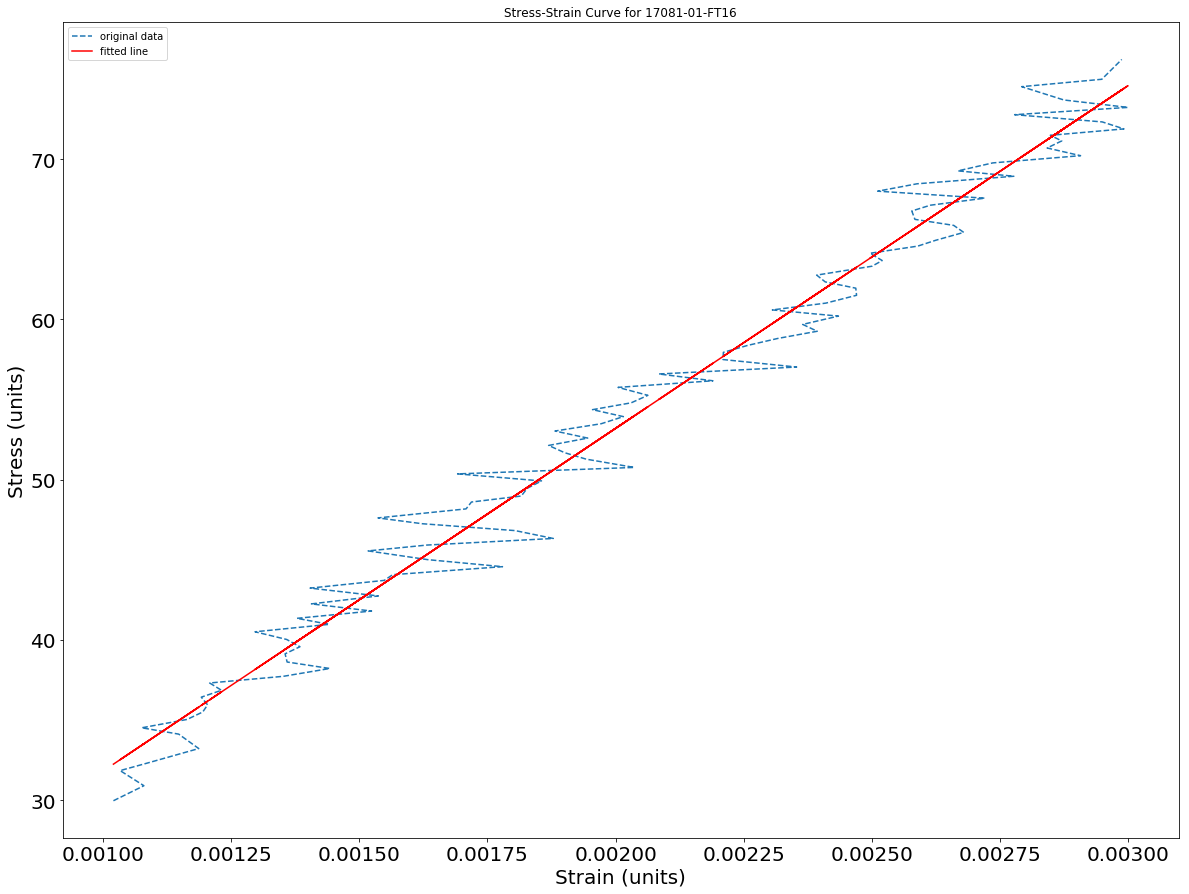

The Modulus IAW ISO 527 is 21.394049 GPa


In [686]:
ISO_527_strain = []
Force_in_strain_range = []

for ext, force in zip(tensile['Axial Extensometer'], tensile['Axial Force']):
    if ext > 0.001 and ext < 0.003:
        ISO_527_strain.append(ext)
        Force_in_strain_range.append(force)
ISO_527_stress = np.array(Force_in_strain_range/(1000*Area))
ISO_527_strain = np.array(ISO_527_strain)

slope, intercept, r_value, p_value, std_err = stats.linregress(ISO_527_strain, ISO_527_stress)
print("r-squared:", r_value**2)

#plt.plot(ISO_527_strain, ISO_527_stress, 'o', label='original data')
#plt.plot(x, intercept + slope*x, 'r', label='fitted line')
# plt.legend()
# plt.show()

plt.figure(figsize = (20,15))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.plot(ISO_527_strain, ISO_527_stress,'--',label='original data')
plt.plot(ISO_527_strain, intercept + slope*ISO_527_strain, 'r', label='fitted line')
plt.xlabel('Strain (units)', fontsize = 20)
plt.ylabel('Stress (units)', fontsize = 20)
plt.title(('Stress-Strain Curve for %s') %sample)
plt.legend()
plt.savefig('ISO_527_Stress_Strain_Curve.tiff')
plt.show()

ISO_527_modulus = slope/1000
print(("The Modulus IAW ISO 527 is %f GPa") %ISO_527_modulus)

# RESULTS

In [687]:
#All_Results = pd.DataFrame[]
Sample_Results = pd.DataFrame({'Sample ID': [sample],'Failure Stress': [Failure_Stress], 'Modulus': [ISO_527_modulus], 'Modulus R Squared Value':r_value**2},columns = ['Sample ID','Failure Stress','Modulus', 'Modulus R Squared Value'])
Results.append(Sample_Results)

#Pipedream_DIC_Data = pd.DataFrame({'DIC Strain': Strain ,'Stress':Stress},columns = ['Strain','Stress'])
#The key here is to time the index of the DIC Data to the time of the MTS Data

# Results = pd.DataFrame({'Result Type':['Uniaxial'],'Ultimate Tensile Strength(Mpa)':[y],'Ultimate Strength(Mpa)':[ucs],
#                         'Youngs Modulus(Gpa)':[E/1000],'R^2':[R2],'Data Points':[K],'CoV(%)':[V]},
#                         columns = ['Result Type','Yield Strength(Mpa)','Ultimate Strength(Mpa)','Youngs Modulus(Gpa)',
#                         'R^2','Data Points','CoV(%)'])
# #Results = pd.DataFrame({'Result Type':['Uniaxial','Mises'],'Yield Strength(Mpa)':[y,y1],'Ultimate Strength(Mpa)':[ucs,ucs1],
# #                        'Youngs Modulus(Gpa)':[E/1000,E1/1000],'Ductility':[d,d1],'R^2':[R2,R2_1],'Data Points':[K,K1],'CoV(%)':[V,V1]},
# #                        columns = ['Result Type','Yield Strength(Mpa)','Ultimate Strength(Mpa)','Youngs Modulus(Gpa)',
# #                                   'Ductility','R^2','Data Points','CoV(%)'])

#ISO_527_Mechanical_Properties.to_csv(ISO_527_Mechanical_Properties.csv)

return Results.to_csv('Results.csv')
# Data.to_csv('Data.csv')

print(Results)

SyntaxError: 'return' outside function (<ipython-input-687-c75d418f4e7d>, line 19)

# Anything below this point is only for my reference

In [ ]:
# # Find Modulus as defined by ISO 527

# modulus = []
    
# for i in range(0,len(ISO_527_stress)-10):
#     modulus.append((ISO_527_stress[i+10] - ISO_527_stress[i])/(ISO_527_stress[i+10] - ISO_527_stress[i]))
#     m = np.mean(modulus)
#     s = np.std(modulus)
#     p = (s/m)*100
#     if np.floor(p) > 10:
#             global Split_Point
#             Split_Point = strain[i]  
#             break

# print(modulus)

In [ ]:
# #Find split point
# def Split_Stress(stress, strain):
    
#     # Split_point is strain at whaich standard deviation(ymodulus)/mean(ymodulus) > 10 %
    
#     ymodulus = []
    
#     for i in range(0,len(strain)-10):
#         ymodulus.append((stress[i+10] - stress[i])/(strain[i+10] - strain[i]))
#         m = np.mean(ymodulus)
#         s = np.std(ymodulus)
#         p = (s/m)*100
#         if np.floor(p) > 10:
#             global Split_Point
#             Split_Point = strain[i]  
#             break

#     #Calculating Young's Modulus from raw data ey_strain

#     #Filtering out the linear potion of the ey_strain and stress data to find the slope

#     linear_strain = []
#     linear_stress = []
#     strain_deviation = []

#     for i in range(0, len(strain)):
#         if strain[i] < Split_Point:
#             linear_strain.append(strain[i])
#             linear_stress.append(stress[i])
    
#     linear_strain = np.array(linear_strain)
#     linear_stress = np.array(linear_stress)

#     linear_strain = linear_strain[:,np.newaxis]
           
#     E_trial,r,_,_ = np.linalg.lstsq(linear_strain,linear_stress)    # Finding Young's Modulus by forcing to zero intercept
    
#     # Calculating mean strain deviation for the linear_stress, linear_strain data
    
#     for i in range(0,len(linear_strain)):
#         strain_deviation.append((linear_strain[i] - linear_stress[i]/E_trial))
        
#     mean_strain_deviation = np.mean(strain_deviation)
    
#     # Filtering out the stress, strain data with strain deviation within bounds 
#     # of mean strain deviation +/- Extensometer least count
            
#     filtered_stress =[]
    
#     for i in range(0,len(strain)):
#             if mean_strain_deviation-0.00005 < (strain[i]- (stress[i]/E_trial)) < mean_strain_deviation + 0.00005 :
#                 filtered_stress.append(stress[i])
#     break_stress = np.max(filtered_stress)
#     return(break_stress)
# print('done')

# Finding Mechanical Properties

In [ ]:
# # Function to calculate Mechanical Properties

# def Mechanical_Properties(stress, strain, split_stress):

#     #Calculating Young's Modulus from raw data ey_strain

#     #Filtering out the linear potion of the ey_strain and stress data to find the slope

#     linear_strain = []
#     linear_stress = []

#     for i in range(0, len(stress)):
#         if stress[i] < split_stress:
#             linear_strain.append(strain[i])
#             linear_stress.append(stress[i])

#     # Filtering out the linear potion of the ey_strain and stress data to fit a polynomial

#     nonlinear_strain =[]
#     nonlinear_stress =[]

#     for i in range(0,len(stress)):
#         if stress[i] > split_stress:
#             nonlinear_strain.append(strain[i])
#             nonlinear_stress.append(stress[i])
            
#     linear_strain = np.array(linear_strain)
#     linear_stress = np.array(linear_stress)

#     linear_strain = linear_strain[:,np.newaxis]

#     E,r,_,_ = np.linalg.lstsq(linear_strain,linear_stress)
    

#     #Calculating R^2 value
#     K = len(linear_stress)
#     r_squared =  1 - r /(K * linear_stress.var())

#     #Calculating coefficient of variation
#     V = 100*np.sqrt(((1/r_squared)-1)/(K-2))
    
    
#     #Fitting a polynomial curve to the nonlinear portion of stress-strain curve
#     #p = np.polyfit(nonlinear_strain,nonlinear_stress,20)
#     #p1d = np.poly1d(p)
    
    
#     #Finding Ultimate Stress and Strain
#     ucs = np.amax(stress)
#     ucstrain = np.max(strain)
#     #oldcode  ucs = np.amax(stress)    ucstrain = np.amax(strain)


#     # To find yield stress from initially filtered data of Engineering strain vs Engineering stress
#     # This works by finding intersection point of the straight line and polynomial

#     x = np.linspace(0.002,0.05,100000)

#     for i in range(0,len(x)):
#         if (E*(x[i] -0.002)) > (p1d(x[i])):
#             yieldstrain = x[i]
#             yieldstress = p1d(x[i])
#             break 

#     #Caculating ductility from filtered data ey_strain
        
#     #ductility = (ucstrain - yieldstrain)*100
#     return(yieldstress,ucs,E,r_squared,K,V)

# print("done")



In [ ]:
# #Mechanical properties in different processing conditions

# uniaxial_split = Split_Stress(Stress,Strain)   # Passing uniaxial strain, uniaxial stress
# print(uniaxial_split)
# #mises_split = Split_Stress(Stress, Mises)      # Passing mises strain, uniaxial stress
# #print(mises_split)

# [y,ucs,E,R2,K,V] = Mechanical_Properties(Stress,Strain,uniaxial_split)


# #[y1,ucs1,E1,d1,R2_1,K1,V1] = Mechanical_Properties(Stress,Mises,mises_split)

# dir = 'Results'
# if not os.path.exists(dir):
#     os.makedirs(dir)
# else:
#     shutil.rmtree(dir)           #removes all the subdirectories!
#     os.makedirs(dir)

# os.chdir('Results')



# Data = pd.DataFrame({'Strain':Strain,'Stress':Stress},columns = ['Strain','Stress'])

# Results = pd.DataFrame({'Result Type':['Uniaxial'],'Yield Strength(Mpa)':[y],'Ultimate Strength(Mpa)':[ucs],
#                         'Youngs Modulus(Gpa)':[E/1000],'R^2':[R2],'Data Points':[K],'CoV(%)':[V]},
#                         columns = ['Result Type','Yield Strength(Mpa)','Ultimate Strength(Mpa)','Youngs Modulus(Gpa)',
#                         'R^2','Data Points','CoV(%)'])
# #Results = pd.DataFrame({'Result Type':['Uniaxial','Mises'],'Yield Strength(Mpa)':[y,y1],'Ultimate Strength(Mpa)':[ucs,ucs1],
# #                        'Youngs Modulus(Gpa)':[E/1000,E1/1000],'Ductility':[d,d1],'R^2':[R2,R2_1],'Data Points':[K,K1],'CoV(%)':[V,V1]},
# #                        columns = ['Result Type','Yield Strength(Mpa)','Ultimate Strength(Mpa)','Youngs Modulus(Gpa)',
# #                                   'Ductility','R^2','Data Points','CoV(%)'])



# Results.to_csv('Results.csv')
# Data.to_csv('Data.csv')

# print(Results)

# Plot 

In [ ]:
# #plt.cla()
# #plt.clf()
# plt.figure(figsize = (20,15))
# plt.rc('xtick', labelsize=20) 
# plt.rc('ytick', labelsize=20)
# plt.plot(Strain,Stress,'--')
#     #plt.plot(b,a,'-')
#     #plt.plot(g,c,'-')
# plt.xlabel('Engineering Strain (mm/mm)', fontsize = 20)
# plt.ylabel('Engineering Stress (Mpa)', fontsize = 20)
# plt.axis([0.0005,0.0025,0,500])
# plt.savefig('Eng_Strain_Stress.tiff')
# plt.show()




# Linear regression

In [ ]:
# visualize the relationship between the features and the response using scatterplots
#fig, axs = plt.subplots(1, 3, sharey=True)
#tensile.plot(kind='scatter', x=Strain, y=Stress, ax=axs[0], figsize=(16, 8))
#data.plot(kind='scatter', x='Radio', y='Sales', ax=axs[1])
#data.plot(kind='scatter', x='Newspaper', y='Sales', ax=axs[2])

# create a fitted model in one line
#lm = smf.ols(formula='Stress ~ Strain', data=tensile).fit()

# print the coefficients
#lm.params

#fig, ax = plt.subplots()
#fit = np.polyfit(Strain, Stress, deg=1)
#ax.plot(Strain, fit[0] * Strain + fit[1], color='red')
#ax.scatter(Strain, Stress)

#fig.show()

#import seaborn as sns
#sns.lmplot(x=Strain,y=Stress,data=tensile,fit_reg=True) 
# Set the data
#data = pd.DataFrame(tensile)
# Get the linear models
#lm_original = np.polyfit(data.Strain, data.Stress, 1)
 
# calculate the y values based on the co-efficients from the model
#r_x, r_y = (i, x coefficient[0] + coefficient[1])
 
# Put in to a data frame, to keep is all nice
#lm_original_plot = pd.DataFrame({
#Stress : r_x,
#Strain : r_y})


#np.linalg.lstsq(Strain, Stress, rcond=-1)